In [1]:
import sys, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Figure out the repo root by walking up until we find a sibling "src/".
CWD = Path.cwd()
if (CWD / "src").is_dir():
    PROJECT_ROOT = CWD
elif (CWD.parent / "src").is_dir():
    PROJECT_ROOT = CWD.parent
elif (CWD.parent.parent / "src").is_dir():
    PROJECT_ROOT = CWD.parent.parent
else:
    raise RuntimeError("Could not find a 'src' folder above the current working directory.")
sys.path.append(str(PROJECT_ROOT / "src"))
print("PROJECT_ROOT:", PROJECT_ROOT)

# Prefer the project’s path helper; fall back to a simple join if it’s not importable.
try:
    from paths import p
except Exception:
    def p(rel: str | Path) -> Path:
        return (PROJECT_ROOT / Path(rel)).resolve()

# Main input panel for these notebooks/experiments.
CRSP_PARQUET = p("data/processed/crsp_monthly_core.parquet")
print("Parquet:", CRSP_PARQUET)

# MI/entropy tooling used in the redundancy-kernel experiments.
from npeet import entropy_estimators as ee
from sklearn.feature_selection import mutual_info_regression
import warnings

# A couple of defaults so plots are readable without manual tweaking every time.
plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.grid"] = True


PROJECT_ROOT: C:\Users\bseis\ABthesis
Parquet: C:\Users\bseis\ABthesis\data\processed\crsp_monthly_core.parquet


In [2]:
def _coerce_to_datetime_month_end(s) -> pd.DatetimeIndex:
    """
    Convert dates into a month-end DatetimeIndex.

    This accepts pretty much anything pandas can parse (Series, Index, arrays, lists)
    and standardizes everything to month-end so joins/pivots behave predictably.
    """
    dt = pd.to_datetime(s)

    # Series uses the .dt accessor; Index/array-like uses PeriodIndex.
    if isinstance(dt, pd.Series):
        return pd.DatetimeIndex(dt.dt.to_period("M").dt.to_timestamp("M").values)

    return pd.PeriodIndex(dt, freq="M").to_timestamp("M")

def _dedupe_by_date_ticker(df: pd.DataFrame, id_col: str, date_col: str) -> pd.DataFrame:
    # If we have enough info to proxy for size, keep the “largest” row within each (id, date).
    if {"prc","shrout"}.issubset(df.columns):
        df["__me"] = np.abs(pd.to_numeric(df["prc"], errors="coerce")) * pd.to_numeric(df["shrout"], errors="coerce")
        df = df.sort_values([id_col, date_col, "__me"]).groupby([id_col, date_col], as_index=False).tail(1)
        df = df.drop(columns="__me")
    else:
        # Otherwise, just keep the last observation after sorting.
        df = df.sort_values([id_col, date_col]).drop_duplicates(subset=[id_col, date_col], keep="last")
    return df

def _warn_on_dupes(df: pd.DataFrame, id_col: str, date_col: str, context: str = "") -> None:
    # Useful guardrail: duplicate keys will silently break pivots unless we collapse them first.
    dupes = df.duplicated(subset=[id_col, date_col], keep=False).sum()
    if dupes:
        print(f"[{context}] Found {dupes} duplicate rows across ({id_col}, {date_col}). Deduping…")

def _build_prices_from_returns(df, id_col: str, date_col: str, ret_col: str) -> pd.DataFrame:
    # If prices aren’t available, construct a synthetic price path by compounding returns.
    tmp = df[[id_col, date_col, ret_col] + [c for c in ("prc","shrout") if c in df.columns]].copy()
    tmp[ret_col] = pd.to_numeric(tmp[ret_col], errors="coerce")
    tmp[date_col] = _coerce_to_datetime_month_end(tmp[date_col])

    _warn_on_dupes(tmp, id_col, date_col, "returns->prices")
    tmp = _dedupe_by_date_ticker(tmp, id_col, date_col)

    tmp = tmp.sort_values([id_col, date_col])
    tmp["rel"] = 1.0 + tmp[ret_col]
    tmp = tmp.dropna(subset=["rel"])

    # Base-100 indexing; only relative moves matter for MI / dependence work.
    tmp["px"] = tmp.groupby(id_col)["rel"].cumprod() * 100.0
    px = tmp.pivot(index=date_col, columns=id_col, values="px")
    return px.sort_index().dropna(how="all")

def _wide_prices_from_price_col(df, id_col: str, date_col: str, price_col: str) -> pd.DataFrame:
    # Standard “wide” price panel: index = date, columns = id (ticker), values = price.
    tmp = df[[id_col, date_col, price_col] + [c for c in ("prc","shrout") if c in df.columns]].copy()
    tmp[date_col] = _coerce_to_datetime_month_end(tmp[date_col])

    _warn_on_dupes(tmp, id_col, date_col, "price->wide")
    tmp = _dedupe_by_date_ticker(tmp, id_col, date_col)

    tmp = tmp.sort_values([id_col, date_col])
    px = tmp.pivot(index=date_col, columns=id_col, values=price_col)
    return px.sort_index().dropna(how="all")

def load_crsp_monthly_prices(parquet_path: Path, tickers=None, start=None, end=None) -> pd.DataFrame:
    # Load the CRSP core panel and return a wide price matrix (tickers as columns).
    df = pd.read_parquet(parquet_path)

    if "date" not in df.columns or "ticker" not in df.columns:
        raise KeyError("Parquet must include 'date' and 'ticker'")

    # Optional ticker subset.
    if tickers is not None:
        df = df[df["ticker"].isin(list(tickers))].copy()
        if df.empty:
            raise ValueError("None of requested tickers present")

    # Basic date filtering (inclusive bounds here).
    if start is not None: df = df[pd.to_datetime(df["date"]) >= pd.to_datetime(start)]
    if end   is not None: df = df[pd.to_datetime(df["date"]) <= pd.to_datetime(end)]
    if df.empty: raise ValueError("No rows after date/ticker filtering")

    # Prefer an explicit price column if present; otherwise fall back to compounding returns.
    price_col = next((c for c in ["adj_prc","adj_price","px","price","prc_adj","prc"] if c in df.columns), None)
    if price_col:
        px = _wide_prices_from_price_col(df, "ticker", "date", price_col)
    else:
        ret_col = "ret" if "ret" in df.columns else ("retx" if "retx" in df.columns else None)
        if ret_col is None:
            raise KeyError("Found neither price nor ('ret'/'retx') columns.")
        px = _build_prices_from_returns(df, "ticker", "date", ret_col)

    # Preserve column order if a list of tickers was given.
    if tickers is not None:
        px = px.reindex(columns=list(tickers))

    return px.dropna(how="all")

In [5]:
def mi_npeet(x, y, k=4, return_bits=True):
    I = ee.mi(np.asarray(x), np.asarray(y), k=k)
    return float(I/np.log(2.0) if return_bits else I)

def mi_sklearn(x, y, k=4, return_bits=True, random_state=0):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).ravel()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mi_xy = mutual_info_regression(X=x, y=y, n_neighbors=k, random_state=random_state)[0]
        mi_yx = mutual_info_regression(X=y.reshape(-1,1), y=x.ravel(), n_neighbors=k, random_state=random_state)[0]
    I = 0.5*(mi_xy + mi_yx)
    return float(I/np.log(2.0) if return_bits else I)

In [7]:
def get_all_tickers(parquet_path: Path) -> list[str]:
    # Pull the ticker universe directly from the parquet (fast: one column).
    df = pd.read_parquet(parquet_path, columns=["ticker"])
    return sorted(pd.Index(df["ticker"]).dropna().unique().tolist())

def standardize(df: pd.DataFrame) -> pd.DataFrame:
    # Column-wise z-score with population std (ddof=0) so it's deterministic across runs.
    return (df - df.mean()) / df.std(ddof=0)

def collect_pairs(
    *,
    target_neg_pairs: int = 4000, 
    max_batches: int = 200,
    sample_size: int = 90,
    pair_subsample: int = 3000, 
    start: str = "2016-01-01",
    end: str   = "2018-12-31",
    k: int = 4,
    min_pair_obs: int = 36,
    seed: int = 123,
):
    rng = np.random.default_rng(seed)
    universe = get_all_tickers(CRSP_PARQUET)

    # Store rows as dicts and turn into DataFrames at the end.
    neg_rows = []
    pos_rows = []

    for b in range(1, max_batches+1):
        # Random batch of tickers (no replacement within a batch).
        sample = sorted(rng.choice(universe, size=sample_size, replace=False).tolist())

        # Load prices for just this batch and date window.
        px = load_crsp_monthly_prices(CRSP_PARQUET, tickers=sample, start=start, end=end)

        # Log returns; standardize so MI is not being driven by scale differences.
        rets = np.log(px / px.shift(1))
        rets = standardize(rets)

        tickers = list(rets.columns)

        # Build candidate pairs and optionally subsample so we don't do O(n^2) work each batch.
        all_pairs = [(i, j) for i in range(len(tickers)) for j in range(i+1, len(tickers))]
        if pair_subsample and pair_subsample < len(all_pairs):
            all_pairs = rng.choice(all_pairs, size=pair_subsample, replace=False).tolist()

        for (i, j) in all_pairs:
            xi = rets.iloc[:, i]; yj = rets.iloc[:, j]
            mask = xi.notna() & yj.notna()
            n = int(mask.sum())
            if n < min_pair_obs:
                continue

            x = xi[mask].to_numpy(); y = yj[mask].to_numpy()

            # NPEET estimate first; it's the gate for whether we keep the pair.
            I_np = mi_npeet(x, y, k=k, return_bits=True)

            # Compute the sklearn estimate only for pairs we keep (or might keep).
            I_sk = mi_sklearn(x, y, k=k, return_bits=True, random_state=seed + b)

            row = {
                "a": tickers[i], "b": tickers[j], "n": n,
                "npeet": I_np, "sklearn": I_sk, "diff": I_sk - I_np,
                "batch": b
            }

            if I_np <= 0:
                neg_rows.append(row)
            else:
                # Keep a roughly size-matched control set so later comparisons are cleaner.
                if len(pos_rows) < len(neg_rows) * 1.1:
                    pos_rows.append(row)

        # Stop once we have enough negatives for analysis.
        if len(neg_rows) >= target_neg_pairs:
            break

        # Lightweight progress so you can see if the run is actually producing negatives.
        if b % 5 == 0:
            print(f"[batch {b}] collected negatives so far: {len(neg_rows)}")

    df_neg = pd.DataFrame(neg_rows)
    df_pos = pd.DataFrame(pos_rows)
    return df_neg, df_pos

# Run the collection with one set of parameters and time it.
t0 = time.perf_counter()
df_neg, df_pos = collect_pairs(
    target_neg_pairs=5000, max_batches=150,
    sample_size=100, pair_subsample=4000,
    start="2016-01-01", end="2018-12-31",
    k=4, min_pair_obs=30, seed=42
)
t1 = time.perf_counter()

print(f"Collected: negatives={len(df_neg)} | positives={len(df_pos)} in {t1-t0:.1f}s")
df_neg.head()

[returns->prices] Found 72 duplicate rows across (ticker, date). Deduping…
[batch 5] collected negatives so far: 448
[returns->prices] Found 72 duplicate rows across (ticker, date). Deduping…
[batch 10] collected negatives so far: 983
[returns->prices] Found 2 duplicate rows across (ticker, date). Deduping…
[batch 15] collected negatives so far: 1530
[returns->prices] Found 72 duplicate rows across (ticker, date). Deduping…
[batch 20] collected negatives so far: 1949
[returns->prices] Found 2 duplicate rows across (ticker, date). Deduping…
[returns->prices] Found 72 duplicate rows across (ticker, date). Deduping…
[batch 25] collected negatives so far: 2463
[returns->prices] Found 74 duplicate rows across (ticker, date). Deduping…
[batch 30] collected negatives so far: 2844
[batch 35] collected negatives so far: 3318
[returns->prices] Found 16 duplicate rows across (ticker, date). Deduping…
[returns->prices] Found 72 duplicate rows across (ticker, date). Deduping…
[batch 40] collected n

,a,b,n,npeet,sklearn,diff,batch
0,NVRO,SR,32,-0.174403,0.0,0.174403,1
1,CBSH,SIGM,30,-0.034242,0.0,0.034242,1
2,FFBC,SIGM,30,-0.043928,0.0,0.043928,1
3,SIGM,SSB,30,-0.208074,0.0,0.208074,1
4,CBSH,KIN,35,-0.122506,0.0,0.122506,1


In [8]:
def summarize(df: pd.DataFrame, label: str) -> pd.Series:
    if df.empty:
        return pd.Series(name=label, dtype=float)
    return pd.Series({
        "n_pairs": len(df),
        "mean_n": df["n"].mean(),
        "mean_npeet": df["npeet"].mean(),
        "mean_sklearn": df["sklearn"].mean(),
        "mean_diff": df["diff"].mean(),
        "std_diff": df["diff"].std(),
        "mae_diff": df["diff"].abs().mean(),
        "p95_abs_diff": df["diff"].abs().quantile(0.95),
        "share_sklearn_neg": (df["sklearn"] <= 0).mean(),
        "corr_np_sk": df["npeet"].corr(df["sklearn"]) if df["npeet"].std() and df["sklearn"].std() else np.nan,
    }, name=label)

summary = pd.concat([summarize(df_neg, "NPEET<=0"), summarize(df_pos, "NPEET>0")], axis=1)
summary.round(4)

,NPEET<=0,NPEET>0
n_pairs,5004.0000,5463.0000
mean_n,34.6493,34.6656
mean_npeet,-0.1010,0.1554
mean_sklearn,0.0001,0.1076
mean_diff,0.1010,-0.0478
std_diff,0.0716,0.0417
mae_diff,0.1010,0.0481
p95_abs_diff,0.2372,0.1272
share_sklearn_neg,0.9940,0.0044
corr_np_sk,0.0688,0.9978


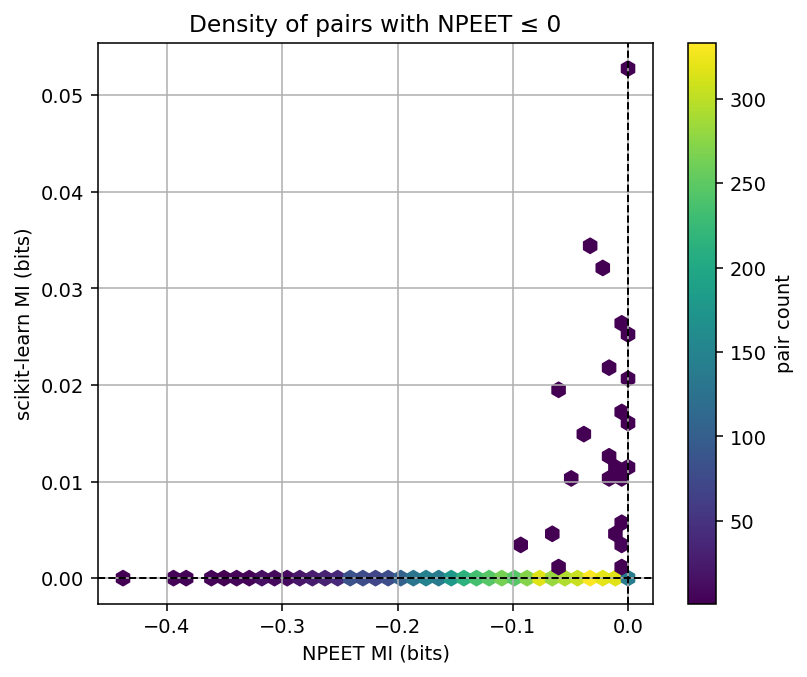

In [9]:
if not df_neg.empty:
    plt.figure(figsize=(6.4,5.2))
    hb = plt.hexbin(df_neg["npeet"], df_neg["sklearn"], gridsize=40, mincnt=1, cmap="viridis")
    plt.colorbar(hb, label="pair count")
    plt.axvline(0, ls="--", c="k", lw=1)
    plt.axhline(0, ls="--", c="k", lw=1)
    plt.xlabel("NPEET MI (bits)")
    plt.ylabel("scikit-learn MI (bits)")
    plt.title("Density of pairs with NPEET ≤ 0")
    plt.show()

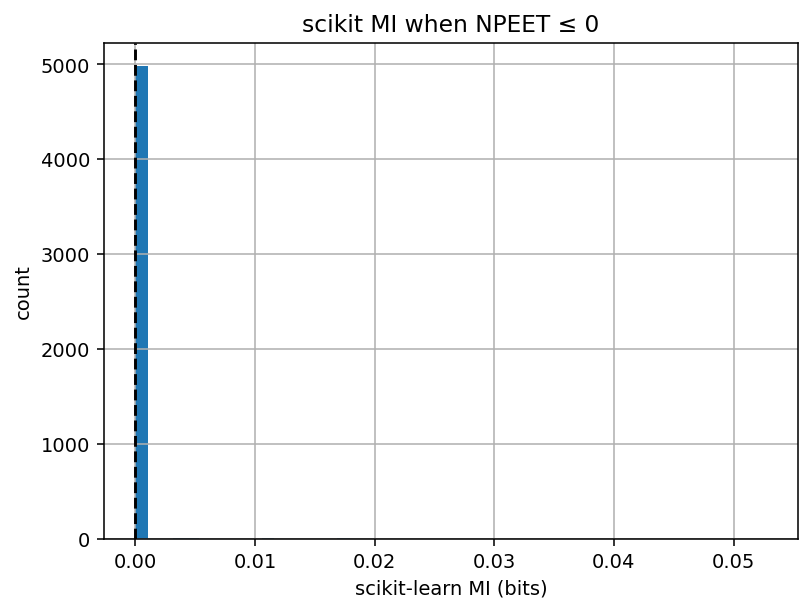

In [33]:
if not df_neg.empty:
    plt.figure(figsize=(6.4,4.6))
    plt.hist(df_neg["sklearn"], bins=50)
    plt.axvline(0, ls="--", c="k")
    plt.xlabel("scikit-learn MI (bits)")
    plt.ylabel("count")
    plt.title("scikit MI when NPEET ≤ 0")
    plt.show()

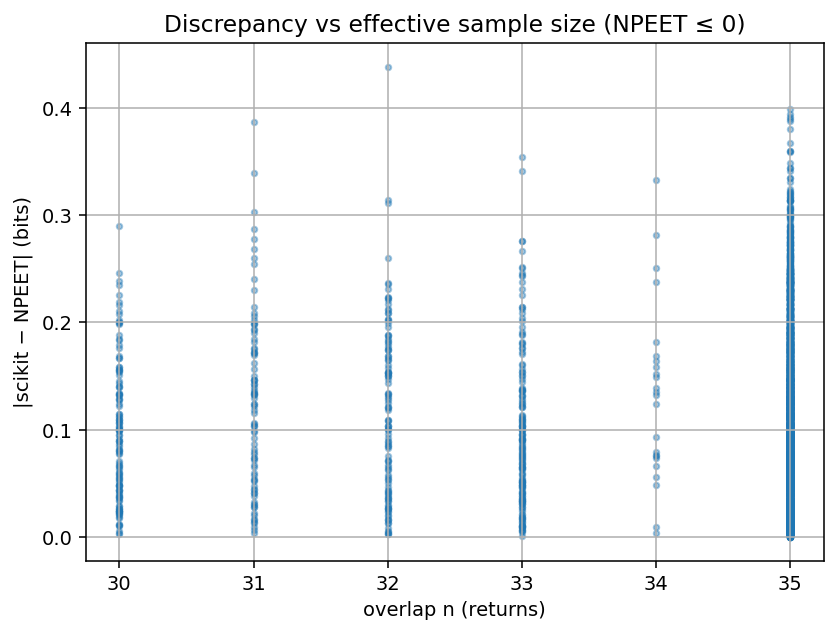

In [11]:
if not df_neg.empty:
    plt.figure(figsize=(6.8,4.8))
    plt.scatter(df_neg["n"], df_neg["diff"].abs(), s=8, alpha=0.4)
    plt.xlabel("overlap n (returns)")
    plt.ylabel("|scikit − NPEET| (bits)")
    plt.title("Discrepancy vs effective sample size (NPEET ≤ 0)")
    plt.show()

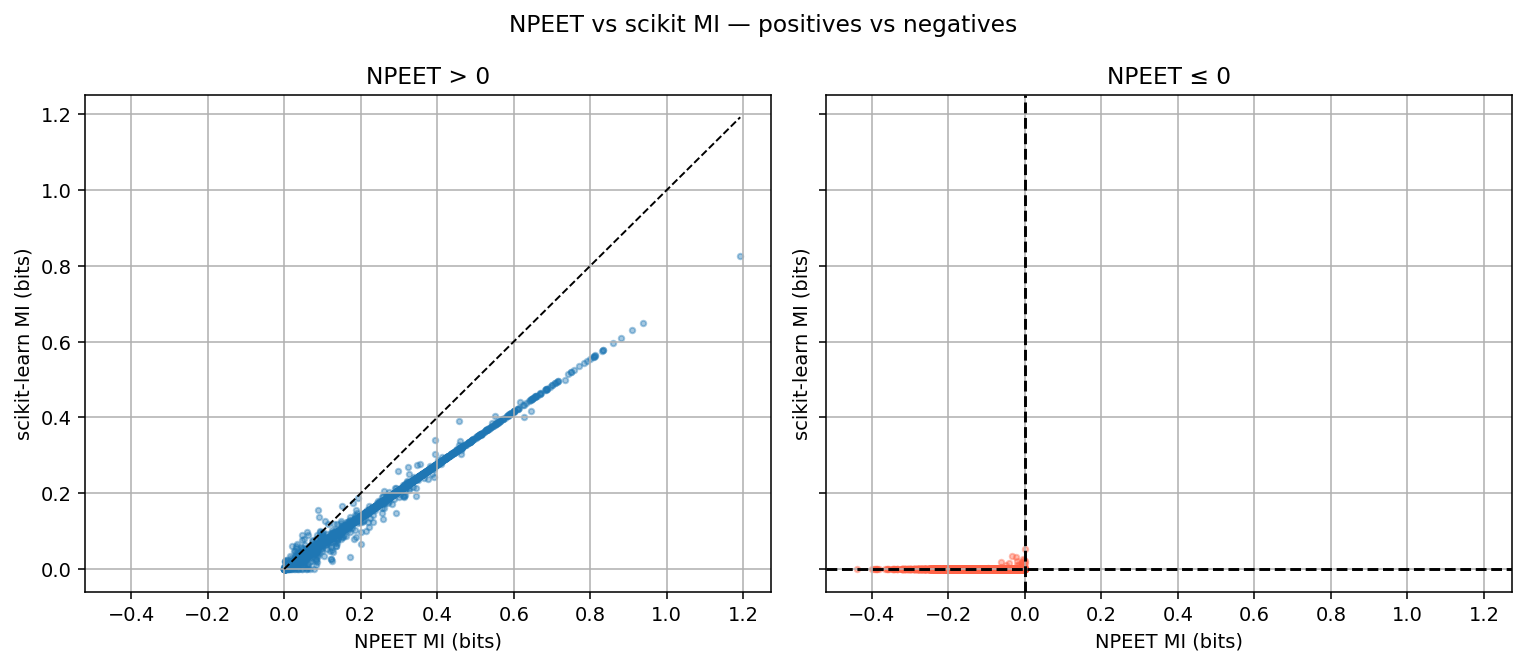

In [94]:
fig, ax = plt.subplots(1,2, figsize=(11,4.8), sharex=True, sharey=True)

if not df_pos.empty:
    ax[0].scatter(df_pos["npeet"], df_pos["sklearn"], s=8, alpha=0.4)
    ax[0].plot([df_pos["npeet"].min(), df_pos["npeet"].max()],
               [df_pos["npeet"].min(), df_pos["npeet"].max()], ls="--", c="k", lw=1)
    ax[0].set_title("NPEET > 0")

if not df_neg.empty:
    ax[1].scatter(df_neg["npeet"], df_neg["sklearn"], s=8, alpha=0.4, color="tomato")
    ax[1].axvline(0, ls="--", c="k"); ax[1].axhline(0, ls="--", c="k")
    ax[1].set_title("NPEET ≤ 0")

for a in ax:
    a.set_xlabel("NPEET MI (bits)")
    a.set_ylabel("scikit-learn MI (bits)")

plt.suptitle("NPEET vs scikit MI — positives vs negatives")
plt.tight_layout()
plt.show()